In [266]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical

## Without Sampling

In [267]:
# Load the dataset
data = pd.read_csv('/content/sample_data/train.csv')

In [268]:
# Drop the rows where the value of specific columns is empty
data.dropna(subset=['Profession', 'Gender', 'Graduated', 'Ever_Married', 'Spending_Score', 'Var_1', 'Segmentation'], inplace=True)

# Print the shape of the cleaned dataset
print("Shape of the cleaned dataset:", data.shape)

Shape of the cleaned dataset: (7669, 11)


In [269]:
# Replace missing values with mean value for specific columns
cols = ['Age', 'Work_Experience', 'Family_Size']
for col in cols:
  data[col].fillna(data[col].mean(), inplace=True)
# Print the head of the cleaned dataset
print("Head of the cleaned dataset:\n")
data.head()

Head of the cleaned dataset:



,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.000000,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,2.636206,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.000000,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.000000,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,2.636206,High,6.0,Cat_6,A


In [270]:
def pre_process_data(df):
  subset=['Profession', 'Gender', 'Graduated', 'Ever_Married', 'Spending_Score', 'Var_1']
  data.drop(['ID'], axis=1, inplace=True)
  if 'Segmentation' in df.columns:
    subset.append('Segmentation')
  # Drop the rows where the value of specific columns is empty
  df.dropna(subset=subset, inplace=True)
  # Print the shape of the cleaned dataset
  print("Shape of the cleaned dataset:", df.shape)
  # Replace missing values with mean value for specific columns
  cols = ['Age', 'Work_Experience', 'Family_Size']
  for col in cols:
    df[col].fillna(df[col].mean(), inplace=True)

In [271]:
# Get a list of categorical features
cat_feats = list(data.select_dtypes(include=['object']).columns)

print(cat_feats)

['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1', 'Segmentation']


In [272]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

for col in cat_feats:
  data[col] = label_encoder.fit_transform(data[col])

data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,1,0,22,0,5,1.000000,2,4.0,3,3
1,462643,0,1,38,1,2,2.636206,0,3.0,3,0
2,466315,0,1,67,1,2,1.000000,2,1.0,5,1
3,461735,1,1,67,1,7,0.000000,1,2.0,5,1
4,462669,0,1,40,1,3,2.636206,1,6.0,5,0


In [307]:
def encode_features(df):
  cat_feats = list(data.select_dtypes(include=['object']).columns)
  for col in cat_feats:
    df[col] = label_encoder.fit_transform(df[col])

In [274]:
# Split the dataset into features and target variable
X = data.drop(['ID', 'Segmentation'], axis=1)
y = data['Segmentation']

X, y = shuffle(X, y, random_state=42)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the training and validation sets
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (6135, 9)
Shape of y_train: (6135,)
Shape of X_val: (1534, 9)
Shape of y_val: (1534,)


In [275]:
X.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
3110,0,0,35,1,5,9.0,2,1.0,5
4631,1,1,36,0,4,1.0,1,6.0,3
3613,1,0,22,0,8,4.0,2,3.0,5
3288,0,0,31,0,5,9.0,2,1.0,5
1818,1,0,45,1,0,5.0,2,1.0,3


In [276]:
num_features = len(X.columns)
num_classes = len(np.unique(y.values))
print(num_features, num_classes)

9 4


In [277]:
y_train.shape, y_val.shape

((6135,), (1534,))

In [287]:
# Define the model architecture
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(num_features,)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

In [279]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1


In [280]:
# Compile the model with appropriate loss and metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])


In [281]:
# Define early stopping callback
es = EarlyStopping(monitor='val_f1_score', mode='max', verbose=1, patience=10)

In [282]:
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)

In [ ]:
# Train the model with validation data and early stopping
history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_val, y_val_encoded), callbacks=[es])

Epoch 1/100
192/192 [==============================] - 1s 4ms/step - loss: 1.1080 - accuracy: 0.5097 - f1_score: 0.3691 - val_loss: 1.1049 - val_accuracy: 0.4915 - val_f1_score: 0.3800
Epoch 2/100
192/192 [==============================] - 1s 5ms/step - loss: 1.1064 - accuracy: 0.5053 - f1_score: 0.3680 - val_loss: 1.0980 - val_accuracy: 0.4909 - val_f1_score: 0.3699
Epoch 3/100
192/192 [==============================] - 1s 5ms/step - loss: 1.1032 - accuracy: 0.5148 - f1_score: 0.3655 - val_loss: 1.0960 - val_accuracy: 0.4954 - val_f1_score: 0.3718
Epoch 4/100
192/192 [==============================] - 1s 5ms/step - loss: 1.1020 - accuracy: 0.5107 - f1_score: 0.3724 - val_loss: 1.0984 - val_accuracy: 0.5072 - val_f1_score: 0.3610
Epoch 5/100
192/192 [==============================] - 1s 3ms/step - loss: 1.1027 - accuracy: 0.5077 - f1_score: 0.3693 - val_loss: 1.1068 - val_accuracy: 0.4980 - val_f1_score: 0.3293
Epoch 6/100
192/192 [==============================] - 1s 3ms/step - loss: 

In [ ]:
test_data = pd.read_csv('/content/sample_data/test.csv')
test_data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


In [ ]:
pre_process_data(test_data)

Shape of the cleaned dataset: (2488, 10)


In [ ]:
test_data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,0,1,36,1,2,0.000000,2,1.0,5
1,458994,1,1,37,1,5,8.000000,0,4.0,5
3,459000,1,1,59,0,4,11.000000,1,2.0,5
4,459001,0,0,19,0,8,2.549799,2,4.0,5
5,459003,1,1,47,1,1,0.000000,1,5.0,3


In [ ]:
encode_features(test_data)

In [ ]:
test_data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,0,1,36,1,2,0.000000,2,1.0,5
1,458994,1,1,37,1,5,8.000000,0,4.0,5
3,459000,1,1,59,0,4,11.000000,1,2.0,5
4,459001,0,0,19,0,8,2.549799,2,4.0,5
5,459003,1,1,47,1,1,0.000000,1,5.0,3


In [ ]:
test_data = test_data.drop('ID', axis=1)

In [ ]:
test_data

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,0,1,36,1,2,0.000000,2,1.0,5
1,1,1,37,1,5,8.000000,0,4.0,5
3,1,1,59,0,4,11.000000,1,2.0,5
4,0,0,19,0,8,2.549799,2,4.0,5
5,1,1,47,1,1,0.000000,1,5.0,3
...,...,...,...,...,...,...,...,...,...
2622,1,0,29,0,5,9.000000,2,4.0,5
2623,0,0,35,1,1,1.000000,2,1.0,5
2624,0,0,53,1,3,2.549799,2,2.0,5
2625,1,1,47,1,4,1.000000,1,5.0,3


In [ ]:
test_pred = model.predict(test_data)

78/78 [==============================] - 0s 2ms/step


In [ ]:
test_labels = pd.get_dummies(test_data['Var_1'])
test_labels

,0,1,2,3,4,5,6
0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0
5,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
2622,0,0,0,0,0,1,0
2623,0,0,0,0,0,1,0
2624,0,0,0,0,0,1,0
2625,0,0,0,1,0,0,0


In [ ]:
# Convert the test labels to multiclass format using argmax
test_labels = np.argmax(test_labels.values, axis=1)

# Convert the model's predictions to multiclass format using argmax
test_pred = np.argmax(test_pred, axis=1)

In [300]:
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       0.01      0.12      0.02        33
           1       0.04      0.15      0.06       133
           2       0.05      0.11      0.07       244
           3       0.18      0.45      0.26       365
           4       0.00      0.00      0.00        28
           5       0.00      0.00      0.00      1622
           6       0.00      0.00      0.00        63

    accuracy                           0.09      2488
   macro avg       0.04      0.12      0.06      2488
weighted avg       0.03      0.09      0.05      2488



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Here are the main metrics to look at in this report:

Precision: The precision for each class is the ratio of true positives to the total number of predicted positives for that class. In other words, it measures how often the model correctly predicted the class. For example, the precision for class 3 is 0.18, which means that the model correctly predicted this class 18% of the time.

Recall: The recall for each class is the ratio of true positives to the total number of actual positives for that class. In other words, it measures how often the model correctly identified the class out of all the times the class actually appeared in the test data. For example, the recall for class 3 is 0.45, which means that the model correctly identified 45% of the actual instances of this class in the test data.

F1-score: The F1-score for each class is the harmonic mean of the precision and recall for that class. It takes into account both precision and recall, and is a better measure of overall performance than either metric alone. For example, the F1-score for class 3 is 0.26, which is a weighted average of the precision and recall for this class.

Accuracy: The overall accuracy of the model on the test data is 0.08, which means that the model correctly classified 8% of the instances in the test data.

Macro average: The macro average is the average of the precision, recall, and F1-score for all classes. It gives equal weight to each class, regardless of its size or prevalence in the test data. In this report, the macro average for the F1-score is 0.06.

Weighted average: The weighted average is the weighted average of the precision, recall, and F1-score for all classes, weighted by the number of instances in each class. It gives more weight to larger classes, which may be more important to the overall performance of the model. In this report, the weighted average for the F1-score is 0.05.

Overall, this report shows that the model's performance is very poor, with very low precision, recall, and F1-score for most of the classes.

In [ ]:
# Get the training and validation loss values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']


In [ ]:
# Get the training and validation f1-score values from the history object
f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

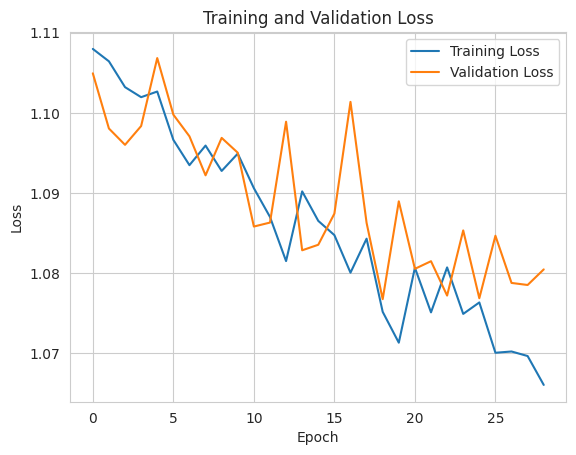

In [ ]:
# Plot the training and validation loss curves
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

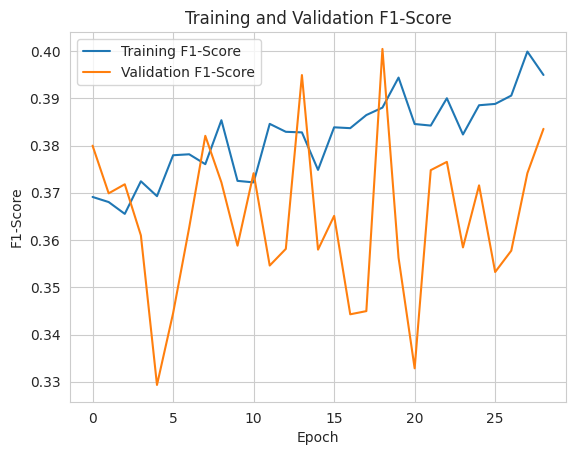

In [ ]:
# Plot the training and validation f1-score curves
plt.plot(f1_score, label='Training F1-Score')
plt.plot(val_f1_score, label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute the false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred.ravel())

# Compute the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


## With Sampling

In [283]:
import pandas as pd
from sklearn.utils import shuffle

# Load the dataset
data = pd.read_csv('/content/sample_data/train.csv')

# Shuffle the dataset
data = shuffle(data, random_state=42)

In [293]:
from imblearn.over_sampling import RandomOverSampler

# Define the oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# Fit and apply the oversampling strategy to the training data
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)

# Fit and apply the oversampling strategy to the validation data
X_val_resampled, y_val_resampled = oversample.fit_resample(X_val, y_val)

In [285]:
X_train_resampled

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,1,0,33,0,3,1.0,2,5.000000,2
1,1,0,33,1,5,3.0,2,1.000000,5
2,0,0,41,1,0,0.0,2,4.000000,1
3,0,1,66,0,2,0.0,0,2.000000,3
4,0,0,43,1,0,9.0,2,2.000000,5
...,...,...,...,...,...,...,...,...,...
6408,0,1,45,1,2,3.0,0,2.847343,2
6409,0,1,30,0,6,9.0,2,3.000000,2
6410,1,0,52,1,3,1.0,2,5.000000,3
6411,1,0,42,1,0,1.0,2,1.000000,5


Text(0.5, 1.0, 'Percentage of Data by Category')

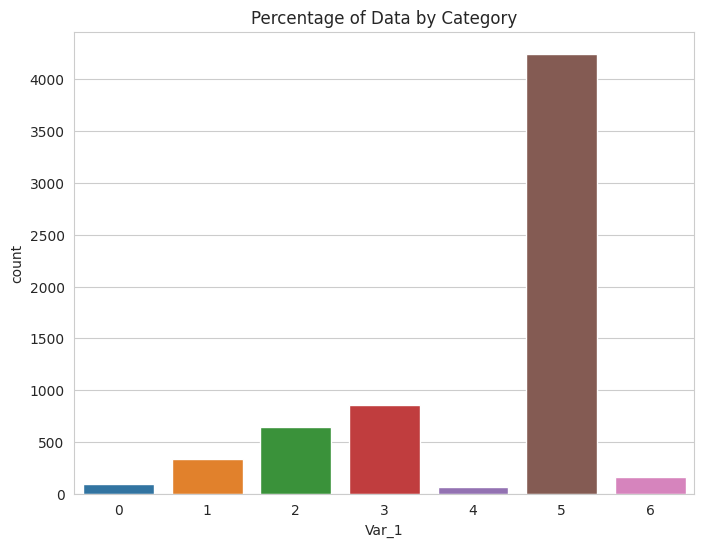

In [286]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
ax = sns.countplot(data=X_train_resampled, x='Var_1')
ax.set_title("Percentage of Data by Category")

In [289]:
num_features = len(X_train_resampled.columns)
num_classes = len(np.unique(y_train_resampled.values))
print(num_features, num_classes)

9 4


In [290]:
# Define the model architecture
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(num_features,)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

In [296]:
# Compile the model with appropriate loss and metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])
# Define early stopping callback
es = EarlyStopping(monitor='val_f1_score', mode='max', verbose=1, patience=10)

y_train_encoded = to_categorical(y_train_resampled)
y_val_encoded = to_categorical(y_val_resampled)

# Train the model with validation data and early stopping
history = model.fit(X_train_resampled, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_val_resampled, y_val_encoded), callbacks=[es])

Epoch 1/100
201/201 [==============================] - 2s 4ms/step - loss: 1.0897 - accuracy: 0.5101 - f1_score: 0.3536 - val_loss: 1.0914 - val_accuracy: 0.5000 - val_f1_score: 0.2932
Epoch 2/100
201/201 [==============================] - 1s 3ms/step - loss: 1.0897 - accuracy: 0.5136 - f1_score: 0.3463 - val_loss: 1.0951 - val_accuracy: 0.5044 - val_f1_score: 0.3280
Epoch 3/100
201/201 [==============================] - 1s 3ms/step - loss: 1.0881 - accuracy: 0.5171 - f1_score: 0.3519 - val_loss: 1.0889 - val_accuracy: 0.5118 - val_f1_score: 0.3393
Epoch 4/100
201/201 [==============================] - 1s 3ms/step - loss: 1.0840 - accuracy: 0.5136 - f1_score: 0.3563 - val_loss: 1.0873 - val_accuracy: 0.5131 - val_f1_score: 0.3148
Epoch 5/100
201/201 [==============================] - 1s 3ms/step - loss: 1.0847 - accuracy: 0.5119 - f1_score: 0.3510 - val_loss: 1.0868 - val_accuracy: 0.5031 - val_f1_score: 0.3192
Epoch 6/100
201/201 [==============================] - 1s 3ms/step - loss: 

In [297]:
# Get the training and validation loss values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the training and validation f1-score values from the history object
f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

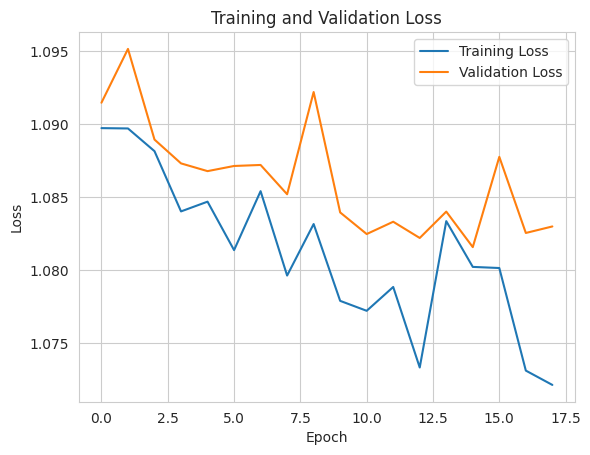

In [298]:
# Plot the training and validation loss curves
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

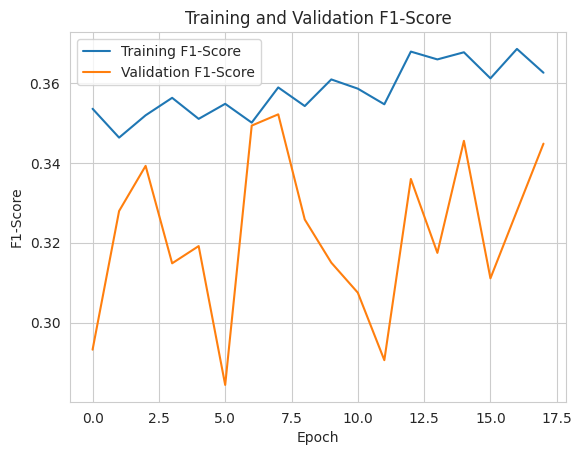

In [299]:
# Plot the training and validation f1-score curves
plt.plot(f1_score, label='Training F1-Score')
plt.plot(val_f1_score, label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

In [313]:
test_data = pd.read_csv('/content/sample_data/test.csv')
test_data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


In [323]:
test_data

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6
...,...,...,...,...,...,...,...,...,...,...
2622,467954,Male,No,29,No,Healthcare,9.0,Low,4.0,Cat_6
2623,467958,Female,No,35,Yes,Doctor,1.0,Low,1.0,Cat_6
2624,467960,Female,No,53,Yes,Entertainment,NaN,Low,2.0,Cat_6
2625,467961,Male,Yes,47,Yes,Executive,1.0,High,5.0,Cat_4


In [324]:
def pre_process_data(df):
  subset=['Profession', 'Gender', 'Graduated', 'Ever_Married', 'Spending_Score', 'Var_1']
  if 'Segmentation' in df.columns:
    subset.append('Segmentation')
  # Drop the rows where the value of specific columns is empty
  df.dropna(subset=subset, inplace=True)
  # Print the shape of the cleaned dataset
  print("Shape of the cleaned dataset:", df.shape)
  # Replace missing values with mean value for specific columns
  cols = ['Age', 'Work_Experience', 'Family_Size']
  for col in cols:
    df[col].fillna(df[col].mean(), inplace=True)

In [325]:
pre_process_data(test_data)

Shape of the cleaned dataset: (2488, 10)


In [326]:
test_data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.000000,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.000000,Average,4.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.000000,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,2.549799,Low,4.0,Cat_6
5,459003,Male,Yes,47,Yes,Doctor,0.000000,High,5.0,Cat_4


In [328]:
test_data = test_data.drop('ID', axis=1)

In [330]:
def encode_features(df):
  cat_feats = list(df.select_dtypes(include=['object']).columns)
  for col in cat_feats:
    df[col] = label_encoder.fit_transform(df[col])

In [331]:
encode_features(test_data)
test_data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,0,1,36,1,2,0.000000,2,1.0,5
1,1,1,37,1,5,8.000000,0,4.0,5
3,1,1,59,0,4,11.000000,1,2.0,5
4,0,0,19,0,8,2.549799,2,4.0,5
5,1,1,47,1,1,0.000000,1,5.0,3


In [332]:
test_pred = model.predict(test_data)

78/78 [==============================] - 0s 3ms/step


In [333]:
test_labels = pd.get_dummies(test_data['Var_1'])

# Convert the test labels to multiclass format using argmax
test_labels = np.argmax(test_labels.values, axis=1)

# Convert the model's predictions to multiclass format using argmax
test_pred = np.argmax(test_pred, axis=1)

In [334]:
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       0.01      0.09      0.01        33
           1       0.05      0.32      0.09       133
           2       0.06      0.07      0.06       244
           3       0.18      0.39      0.25       365
           4       0.00      0.00      0.00        28
           5       0.00      0.00      0.00      1622
           6       0.00      0.00      0.00        63

    accuracy                           0.08      2488
   macro avg       0.04      0.12      0.06      2488
weighted avg       0.04      0.08      0.05      2488



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Here are the main metrics to look at in this report:

Precision: The precision for each class is the ratio of true positives to the total number of predicted positives for that class. In other words, it measures how often the model correctly predicted the class. For example, the precision for class 3 is 0.18, which means that the model correctly predicted this class 18% of the time.

Recall: The recall for each class is the ratio of true positives to the total number of actual positives for that class. In other words, it measures how often the model correctly identified the class out of all the times the class actually appeared in the test data. For example, the recall for class 3 is 0.45, which means that the model correctly identified 45% of the actual instances of this class in the test data.

F1-score: The F1-score for each class is the harmonic mean of the precision and recall for that class. It takes into account both precision and recall, and is a better measure of overall performance than either metric alone. For example, the F1-score for class 3 is 0.26, which is a weighted average of the precision and recall for this class.

Accuracy: The overall accuracy of the model on the test data is 0.08, which means that the model correctly classified 8% of the instances in the test data.

Macro average: The macro average is the average of the precision, recall, and F1-score for all classes. It gives equal weight to each class, regardless of its size or prevalence in the test data. In this report, the macro average for the F1-score is 0.06.

Weighted average: The weighted average is the weighted average of the precision, recall, and F1-score for all classes, weighted by the number of instances in each class. It gives more weight to larger classes, which may be more important to the overall performance of the model. In this report, the weighted average for the F1-score is 0.05.

Overall, this report shows that the model's performance is very poor, with very low precision, recall, and F1-score for most of the classes.

Using RandomOverSampler to balance imbalanced datasets can improve the accuracy of machine learning models by addressing the issue of class imbalance. By randomly oversampling the minority class, RandomOverSampler generates synthetic data points that are similar to the existing data points in the minority class, but with small variations. This helps the model to learn more effectively and make more accurate predictions for the minority class. Additionally, using RandomOverSampler reduces the risk of overfitting that can occur when using all of the available data for training

By oversampling the minority class, the RandomSampler generates synthetic data points that are similar to the existing data points in the minority class, but with small variations. This helps the model to learn more effectively and make more accurate predictions for the minority class. Additionally, using RandomSampler reduces the risk of overfitting that can occur when using all of the available data for training.

Therefore, the results obtained using the sampled data may show improved accuracy, precision, recall, or F1-score when compared to the results obtained using the original imbalanced dataset. However, it is important to note that oversampling can also lead to a longer training time and may not always improve the accuracy.

In conclusion, using RandomSampler to balance imbalanced datasets can help improve the performance of machine learning models by addressing the issue of class imbalance